In [1]:
# !pip install torchmetrics[image]

In [2]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.1 MB/s eta 0:00:00


In [3]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 23.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.3.10.19:
      Successfully uninstalled nvidia-curand-cu12-10.3.10.19
  Attemp

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
from torch.optim.lr_scheduler import *
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from PIL import Image
import numpy as np
from tqdm import tqdm
from einops import rearrange

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
dataroot = "/kaggle/input/50k-celeba-dataset-64x64"
dataset = datasets.ImageFolder(root=dataroot)
                           # transform=transforms.Compose([
                           #     transforms.Resize(image_size),
                           #     transforms.CenterCrop(image_size),
                           #     transforms.ToTensor(),
                           #     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           # ]))

In [7]:
train_ds, test_ds = random_split(dataset, [0.8, 0.2])
train_ds, test_ds

(<torch.utils.data.dataset.Subset at 0x7f6e81abb150>,
 <torch.utils.data.dataset.Subset at 0x7f6e81cbe490>)

In [8]:
train_ds[0]

(<PIL.Image.Image image mode=RGB size=64x64>, 0)

In [9]:
def collate_fn(batch):
    batch_size = len(batch)
    images = np.zeros((batch_size, 64, 64, 3)).astype(np.float32)
    labels = np.zeros(batch_size).astype(np.int32)
    cnt = 0
    for im, label in batch:
        # im = Image.open(pil_file)  
        im.draft('RGB',(64, 64))
        images[cnt] = np.asarray(im)
        labels[cnt] = label
        cnt += 1
    images = images.swapaxes(2, 3).swapaxes(1, 2) / 256
    return torch.from_numpy(images), torch.from_numpy(labels)

In [10]:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
)
test_loader = DataLoader(
    test_ds,
    batch_size=128,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=4,
)

In [11]:
%%time
for x in train_loader:
    print(x[0].shape)
    break

torch.Size([64, 3, 64, 64])
CPU times: user 35.7 ms, sys: 59.8 ms, total: 95.5 ms
Wall time: 831 ms


In [12]:
class SE_Conv(nn.Module):
    def __init__(self, in_channels, out_channels, stride, kernel_size, padding):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=kernel_size, padding=padding)
        self.ffn = nn.Sequential(
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten(),
            nn.Linear(in_channels, 16),
            nn.SiLU(),
            nn.Linear(16, out_channels)
        )
    def forward(self, x):
        weight = self.ffn(x).unsqueeze(-1).unsqueeze(-1)
        x = self.conv(x)
        return x * weight

In [13]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, upsample=False):
        super().__init__()
        if not upsample:
            self.conv1 = nn.Conv2d(in_channels, out_channels, stride=1, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1)
            self.skip = nn.Conv2d(in_channels, out_channels, stride=stride, kernel_size=1, padding=0)
        else:
            self.conv1 = nn.Conv2d(in_channels, out_channels, stride=1, kernel_size=3, padding=1)
            self.conv2 = nn.ConvTranspose2d(out_channels, out_channels, stride=stride, kernel_size=4, padding=1)
            # self.conv2 = nn.Sequential(
            #     nn.Upsample(scale_factor=2, mode='bilinear'),
            #     nn.Conv2d(out_channels, out_channels, stride=1, kernel_size=3, padding=1),
            # )
            self.skip = nn.ConvTranspose2d(in_channels, out_channels, stride=stride, kernel_size=4, padding=1)
            # self.skip = nn.Sequential(
            #     nn.Upsample(scale_factor=2, mode='bilinear'),
            #     nn.Conv2d(in_channels, out_channels, stride=1, kernel_size=3, padding=1),
            # )
        g = min(32, out_channels)
        self.bn1 = nn.GroupNorm(g, out_channels)
        self.bn2 = nn.GroupNorm(g, out_channels)

        self.gamma_mlp = nn.Sequential(
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, out_channels),
            nn.Tanh(),
        )
        self.beta_mlp = nn.Sequential(
            nn.Linear(128, 128),
            nn.SiLU(),
            nn.Linear(128, out_channels),
            nn.Tanh(),
        )
    def forward(self, x, t_embed):
        gamma = self.gamma_mlp(t_embed).unsqueeze(-1).unsqueeze(-1)
        beta = self.beta_mlp(t_embed).unsqueeze(-1).unsqueeze(-1)
        # x = x * (1 + gamma) + beta
        x1 = F.silu(self.bn1(self.conv1(x)))
        # x1 = x1 * (1 + gamma) + beta
        x1 = F.silu(self.bn2(self.conv2(x1)))
        # x1 = x1 * (1 + gamma) + beta
        x = self.skip(x) + x1
        x = x * (1 + gamma) + beta
        return x

In [14]:
class ViT(nn.Module):
    # Patch size = 1
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self
        self.to_patch = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=1, 
            stride=1,
            padding=0
        )
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=out_channels,
            dim_feedforward=128,
            nhead=2,
            activation=nn.GELU(),
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
    def forward(self, x):
        h = x.shape[2]
        w = x.shape[3]
        x = self.to_patch(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.encoder(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h = h, w = w)
        return x

In [15]:
# torch.exp(torch.arange(128) / 16) # [128]
# torch.exp(torch.arange(128) / 16).unsqueeze(0).expand(x.shape[0], -1) # [batch size, 128]
# t.unsqueeze(-1).expand(-1, 128) # [batch size, 128]
# t.unsqueeze(-1).expand(-1, 128) / torch.exp(torch.arange(128) / 16).unsqueeze(0).expand(x.shape[0], -1)

In [16]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pre_conv = ResNetBlock(3, 16, 1)
        self.down1 = ResNetBlock(16, 32, 2)
        self.down2 = ResNetBlock(32, 64, 2)
        self.down3 = ResNetBlock(64, 128, 2)
        self.d3_vit = ViT(64, 64)
        self.bottleneck = ResNetBlock(128, 128, 1)
        self.b_vit = ViT(128, 128)
        self.up2 = ResNetBlock(256, 128, 2, upsample=True)
        self.u2_vit = ViT(128, 128)
        self.up2_c = ResNetBlock(128, 64, 1)
        self.up3 = ResNetBlock(128, 64, 2, upsample=True)
        self.up3_c = ResNetBlock(64, 32, 1)
        self.up4 = ResNetBlock(64, 32, 2, upsample=True)
        self.up4_c = ResNetBlock(32, 32, 1)
        self.out_conv = ResNetBlock(32, 3, 1)
    def forward(self, t, x):
        if t.dim() == 0:
            t = t.expand(x.shape[0])
            t = t.unsqueeze(-1)
        time_embed = torch.exp(torch.arange(128) / 16).unsqueeze(0).expand(x.shape[0], -1)
        time_embed = time_embed.to(device)
        time_embed = (t.expand(-1, 128)) / time_embed
        time_embed = torch.sin(time_embed)
        x0 = self.pre_conv(x, time_embed)
        x1 = self.down1(x0, time_embed)
        x2 = self.down2(x1, time_embed)
        x2 = self.d3_vit(x2) + x2
        x3 = self.down3(x2, time_embed)
        x4 = self.bottleneck(x3, time_embed) + self.b_vit(x3)
        y = torch.cat([x3, x4], dim=1)
        y = self.up2(y, time_embed)
        y = self.u2_vit(y) + y
        y = self.up2_c(y, time_embed)
        y = torch.cat([y, x2], dim=1)
        y = self.up3(y, time_embed)
        y = self.up3_c(y, time_embed)
        y = torch.cat([y, x1], dim=1)
        y = self.up4(y, time_embed)
        y = self.up4_c(y, time_embed)
        y = self.out_conv(y, time_embed)
        return y

In [17]:
model = UNet().to(device)

In [18]:
sum(p.numel() for p in model.parameters())

3759004

In [19]:
test = torch.rand(9, 3, 64, 64).to(device)
test.shape

torch.Size([9, 3, 64, 64])

In [20]:
t = torch.rand(9, 1).to(device)

In [21]:
model(t, test).shape

torch.Size([9, 3, 64, 64])

In [22]:
# from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint as odeint

In [23]:
%%time
odeint(
    model, 
    torch.rand(128, 3, 64, 64).cuda(), 
    torch.tensor([0.0, 1]).cuda(),
    rtol=1e-4,
    atol=1e-4,
    method='rk4',
).shape

CPU times: user 358 ms, sys: 26 ms, total: 384 ms
Wall time: 409 ms


torch.Size([2, 128, 3, 64, 64])

In [24]:
from torcheval.metrics import FrechetInceptionDistance

def train():
    model.train()
    total_loss = 0
    cnt = 0
    for img, _ in (pbar := tqdm(train_loader)):
        img = img.to(device)
        img = img * 2 - 1
        x0 = torch.randn(img.shape).to(device)
        t = torch.rand(img.shape[0], 1).to(device)
        t2 = t.detach().clone().unsqueeze(-1).unsqueeze(-1)
        x_t = t2 * img + (1 - t2) * x0
        v_target = img - x0
        v_pred = model(t, x_t)
        loss = criteria(v_pred.reshape(-1), v_target.reshape(-1))
        # # Sim ODE: FID loss
        # if cnt % 100 == 0:
        #     # do it once every 20 batches as this is quite slow
        #     fid = FrechetInceptionDistance(device = "cuda")
        #     x_pred = odeint(
        #         model, 
        #         x0, 
        #         torch.tensor([0.0, 1]).to(device),
        #         rtol=1e-4,
        #         atol=1e-4,
        #         method='rk4',
        #     )[-1]
        #     x_pred = (x_pred + 1) / 2
        #     x_pred = torch.clamp(x_pred, 0, 1)
        #     fid.update((img + 1) / 2, True)
        #     fid.update(x_pred, False)
        #     loss2 = fid.compute()
        #     ## End Sim ODE: FID loss
        #     ## Sum the loss
        #     loss = loss + 0.002 * loss2 + criteria(x_pred.reshape(-1), img.reshape(-1))
        #     ## End Sum the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        cnt += 1
        pbar.set_description(f"Training Loss: {total_loss / cnt :6f}")
    scheduler.step()

In [25]:
def test():
    model.eval()
    total_loss = 0
    cnt = 0
    with torch.no_grad():
        for img, _ in (pbar := tqdm(test_loader)):
            img = img.to(device)
            img = img * 2 - 1
            x0 = torch.randn(img.shape).to(device)
            t = torch.rand(img.shape[0], 1).to(device)
            t2 = t.detach().clone().unsqueeze(-1).unsqueeze(-1)
            # print(f"t.shape: {t.shape}")
            # print(f"x0.shape: {x0.shape}")
            # print(f"img.shape: {img.shape}")
            x_t = t2 * img + (1 - t2) * x0
            v_target = img - x0
            v_pred = model(t, x_t)
            loss = criteria(v_pred.reshape(-1), v_target.reshape(-1))
            total_loss += loss.item()
            cnt += 1
            pbar.set_description(f"Testing Loss: {total_loss / cnt :6f}")

In [26]:
model = UNet().to(device)

In [27]:
sum(p.numel() for p in model.parameters())

3759004

In [28]:
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=0.75)
criteria = nn.MSELoss()

In [29]:
for _ in range(5):
    train()
    test()

Testing Loss: 0.137646: 100%|██████████| 79/79 [00:08<00:00,  9.73it/s]


In [30]:
from scipy.integrate import solve_ivp

def get_flow(t, x):
    with torch.no_grad():
        x = torch.from_numpy(x).to(device).float()
        x = x.reshape(-1, 3, 64, 64)
        # t = torch.from_numpy(t).to(device).unsqueeze(-1).float()
        t = torch.tensor([t]).to(device).unsqueeze(-1).float()
        return model(t, x).reshape(-1).cpu().numpy()

def generate(num=1):
    model.eval()
    with torch.no_grad():
        x0 = torch.randn(num, 3, 64, 64).to(device)
        sol = solve_ivp(get_flow, np.array([0, 1]), x0.reshape(-1).cpu().numpy(), rtol=1e-6, atol=1e-6)
    return np.clip((sol.y[:, -1] + 1) / 2, 0, 1)

In [31]:
%%time
output = generate(num=8)
output = output.reshape(-1, 3, 64, 64)

CPU times: user 5.73 s, sys: 41.3 ms, total: 5.77 s
Wall time: 3.09 s


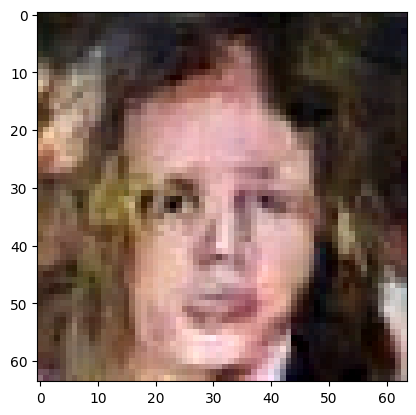

In [32]:
plt.imshow(output[0].swapaxes(0, 1).swapaxes(1, 2))

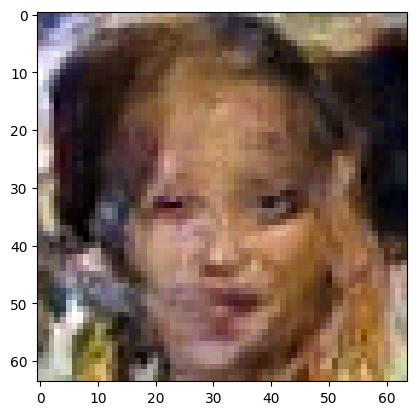

In [33]:
plt.imshow(output[1].swapaxes(0, 1).swapaxes(1, 2))

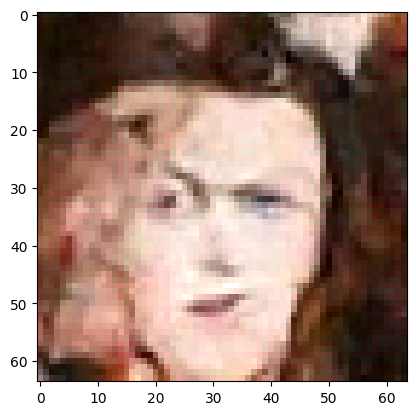

In [34]:
plt.imshow(output[2].swapaxes(0, 1).swapaxes(1, 2))

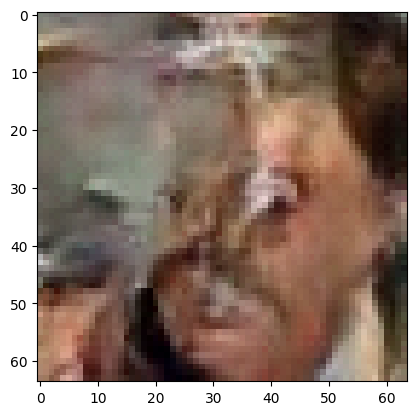

In [35]:
plt.imshow(output[3].swapaxes(0, 1).swapaxes(1, 2))

In [36]:
# from torchmetrics.image.fid import FrechetInceptionDistance
# fid = FrechetInceptionDistance(feature=64)
# from torcheval.metrics import FrechetInceptionDistance
fid = FrechetInceptionDistance(device = "cuda")

idl = iter(train_loader)
for i in tqdm(range(4)):
    # reals = ((next(idl))[0] * 256).type(torch.uint8)
    reals = ((next(idl))[0] * 1).to(device)
    fid.update(reals, True)

for i in tqdm(range(4)):
    fakes = generate(num=128)
    # fakes = torch.from_numpy((fakes.reshape(-1, 3, 64, 64) * 256)).type(torch.uint8)
    fakes = torch.from_numpy((fakes.reshape(-1, 3, 64, 64) * 1)).to(torch.float32).to(device)
    fid.update(fakes, False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 218MB/s] 
100%|██████████| 4/4 [01:02<00:00, 15.71s/it]


In [37]:
fid.compute()

tensor(87.7930, device='cuda:0')

In [38]:
# Best: tensor(65.5430, device='cuda:0')